# Data generation

In [1]:
%load_ext autoreload
%autoreload 2

import segyio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from matplotlib.colorbar import Colorbar
import matplotlib.gridspec as gridspec
import warnings

warnings.filterwarnings("ignore")

In [2]:
def modify_model(vel_mod, top, base, left, right, vel2ch, k):
    """
    This function modifies a velocity model in a certain region which is bounded by
    the values of the parameters top, base, left and right. vel2ch refers to the 
    current velocity in the region that we would like to modify by replacing it
    by a constant k:
    """
    new_vel_mod = vel_mod.astype(float)
    for j in np.arange(left, right + 1):
        for i in np.arange(top, base + 1):
            if new_vel_mod[i, j] == vel2ch:
                new_vel_mod[i, j] = k

    return new_vel_mod

In [3]:
def plotter_4D(m1, m2, m3,  dt=1, type='impedance', perc=1,  height=4, width=15, cmap='seismic_r'):
    vmin, vmax = np.percentile(m1, [perc, 100 - perc])

    fig = plt.figure(figsize=(width, height))
    if type == 'seismic':
        gs = gridspec.GridSpec(5, 4, width_ratios=(1, 1, 1, .05), height_ratios=(.1, .5, .5, .5, .1),
                               left=0.1, right=0.9, bottom=0.1, top=0.9,
                               wspace=0.05, hspace=0.05)
        ax0 = fig.add_subplot(gs[:, 0])
        base = ax0.imshow(m1, vmin=-vmax, vmax=vmax, cmap=cmap, extent=[0, m1.shape[1], m1.shape[0] * dt, 0])
        ax0.set_ylabel('TWT $[s]$')
        ax0.set_title('a) data 1')
        ax0.axis('tight');
        ax1 = fig.add_subplot(gs[:, 1])
        ax1.imshow(m2, vmin=-vmax, vmax=vmax, cmap=cmap)
        ax1.set_yticklabels([])
        ax1.set_title('b) data 2')
        ax1.axis('tight');
        ax2 = fig.add_subplot(gs[:, 2])
        ax2.imshow(m3, vmin=-vmax, vmax=vmax, cmap=cmap)
        ax2.set_yticklabels([])
        ax2.set_title('c) data 3')
        ax2.axis('tight')
        ax3 = fig.add_subplot(gs[3:, 3])
        ax3.set_title('Amplitude', loc='left')
        Colorbar(ax=ax3, mappable=base)

    if type == 'impedance':
        gs = gridspec.GridSpec(5, 4, width_ratios=(1, 1, 1, .05), height_ratios=(.1, .5, .3, .5, .1),
                               left=0.1, right=0.9, bottom=0.1, top=0.9,
                               wspace=0.05, hspace=0.05)
        ax0 = fig.add_subplot(gs[:, 0])
        base = ax0.imshow(m1, vmin=vmin, vmax=vmax, cmap='terrain', extent=[0, m1.shape[1], m1.shape[0] * dt, 0])
        ax0.set_ylabel('TWT $[s]$')
        ax0.set_title('a) model 1')
        ax0.axis('tight');
        ax1 = fig.add_subplot(gs[:, 1])
        ax1.imshow(m2, vmin=vmin, vmax=vmax, cmap='terrain')
        ax1.set_yticklabels([])
        ax1.set_title('b) model 2')
        ax1.axis('tight');
        ax2 = fig.add_subplot(gs[:, 2])
        ax2.imshow(m3,  vmin=vmin, vmax=vmax, cmap='terrain')
        ax2.set_yticklabels([])
        ax2.set_title('c) model 3')
        ax2.axis('tight')
        ax3 = fig.add_subplot(gs[3:, 3])
        ax3.set_title('Impedance \n $[m/s*g/cm^3]$', loc='left')
        Colorbar(ax=ax3, mappable=base)


## Models

In [5]:
# Loading the original Hess model
f = segyio.open('./timodel_vp.segy', ignore_geometry=True)
v = segyio.collect(f.trace[:]).T
v = np.where(v != v[200,0], v, 8175) # seal
v = np.where(v != v[400,0], v, 7500) # reservoir

rho = 2. # Density
# Modeling reservoir at layer #6
v1 = modify_model(v, 490, 550, 1900, 2700, v[500,0], 6000)
m1 = v1[::4, ::4]* 0.3048 * rho
# Modeling reservoir at layer #5
v2 = modify_model(v, 300, 430, 1800, 2950, v[300,0], 6000)
m2 = v2[::4, ::4]* 0.3048 * rho
# Modeling reservoir at layer #5
v3 = modify_model(v, 300, 410, 1800, 2950, v[300,0], 6000)
m3 = v3[::4, ::4]* 0.3048 * rho

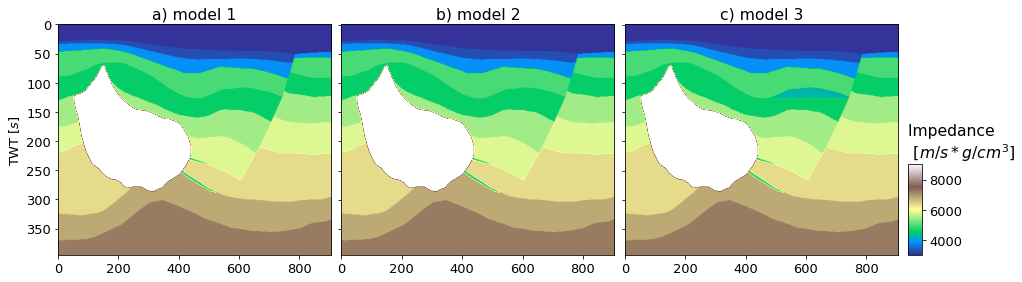

In [22]:
# Loading the model
f = segyio.open('./timodel_vp.segy', ignore_geometry=True)
v = segyio.collect(f.trace[:]).T

# Modifying the model at specific locations Scenario 1:
# The reservoir layer has higher P-wave velocity than the seal rock-layer.
v1 = modify_model(v, 300, 420, 1800, 2950, 8175.984375, 0.90) * 0.3048

# Modifying the model at specific locations Scenario 2:
# The reservoir layer has lower P-wave velocity than the seal rock-layer.
# We then modify also the velocity of the layer above the reservoir (seal)
v2a = np.where(v != 6960.984375, v, 8175)
v2a = np.where(v2a != 8175.984375, v2a, 7500)
v2 = modify_model(v2a, 300, 420, 1800, 2950, 7500, 7000) * 0.3048
v2a = v2a * 0.3048
v = v * 0.3048

plt.rcParams['font.size'] = '13'

# Base model
v_base = np.pad(v2a, ((80, 0), (0, 0)), constant_values=v[0, 0])
v_base = v_base[::4, ::4]

# Monitor
v_mon = np.pad(v2, ((80, 0), (0, 0)), constant_values=v[0, 0])
v_mon = v_mon[::4, ::4]
rho = 2.

m1 = v_base * rho
m2 = v_mon * rho

plotter_4D(m1, m1, m2)

## Post-stack seismic modeling

In [23]:
# Creating Synthetic Seismic data
nt0, nx = m1.shape
dt0 = 0.008
t0 = np.arange(nt0) * dt0

# Wavelet
ntwav = 61
wav, twav, wavc = ricker(t0[:ntwav // 2 + 1], 8)

# Operator
Lop = PoststackLinearModelling(wav / 2, nt0=nt0, spatdims=nx)

# data 1
d1 = Lop * np.log(m1.ravel())
d1 = d1.reshape(nt0, nx)
sigman = 1e-1
n1 = filtfilt(np.ones(10) / 10, 1,
             filtfilt(np.ones(5) / 5, 1, np.random.normal(0, sigman, (nt0, nx)).T, method='gust').T,
             method='gust').ravel()
dn1 = d1 + n1.reshape(nt0, nx)

# data 2
d2 = Lop * np.log(m2.ravel())
d2 = d2.reshape(nt0, nx)
sigman = 1e-1
n2 = filtfilt(np.ones(10) / 10, 1,
             filtfilt(np.ones(5) / 5, 1, np.random.normal(0, sigman, (nt0, nx)).T, method='gust').T,
             method='gust').ravel()
dn2 = d2 + n2.reshape(nt0, nx)

# # data 3
# d3 = Lop * np.log(m3.ravel())
# d3 = d3.reshape(nt0, nx)
# sigman = 1e-1
# n3 = filtfilt(np.ones(10) / 10, 1,
#              filtfilt(np.ones(5) / 5, 1, np.random.normal(0, sigman, (nt0, nx)).T, method='gust').T,
#              method='gust').ravel()
# dn3 = d3 + n3.reshape(nt0, nx)

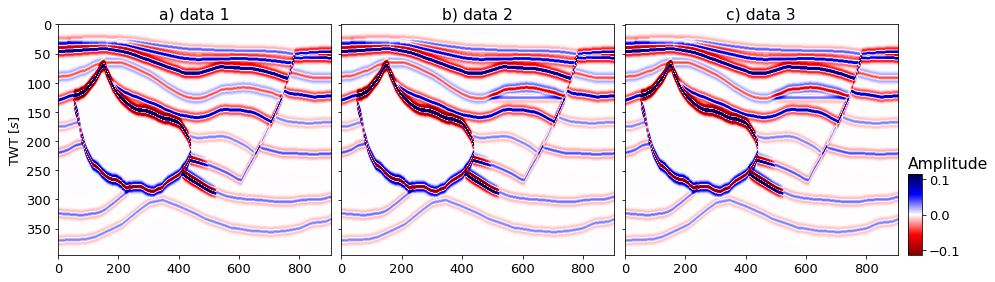

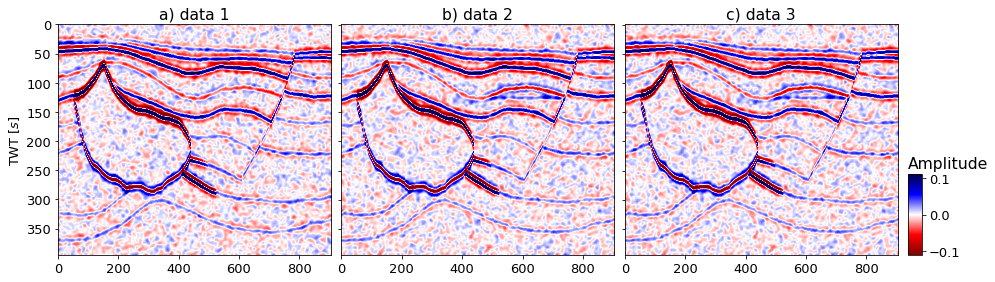

In [24]:
plotter_4D(d1, d2, d2, type='seismic')
plotter_4D(dn1, dn2, dn2, type='seismic')

In [28]:
for n in range(2):
    np.save(f'./Data/Forward/m{n}.npy', [m1, m2][n])
    np.save(f'./Data/Forward/d{n}.npy', [d1, d2][n])
    np.save(f'./Data/Forward/dn{n}.npy', [dn1, dn2][n])